In [1]:
import csv # for reading csv files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # for plotting
import cv2
from cvzone.HandTrackingModule import HandDetector
from IPython.display import clear_output # for clearing the output in the notebook
from sklearn.neighbors import KNeighborsClassifier
from ast import literal_eval
import pickle

# Create a list for labeling
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'space', 'nothing']


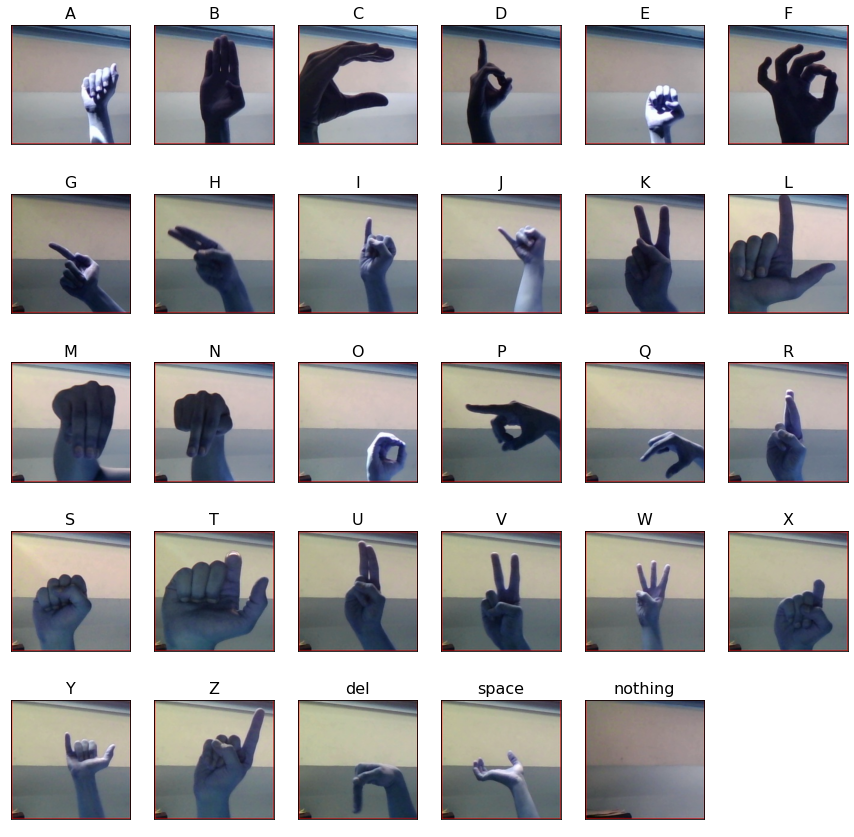

In [2]:
# Show all of the asl letters

f, axarr = plt.subplots(5, 6, figsize=(15, 15))
plt.axis('off')
r, c = 0, 0

for i in range(len(labels)):
    if (i % 6 == 0 and i != 0):
        r += 1
        c = 0
    axarr[r, c].imshow(cv2.imread('data/asl_alphabet_train/asl_alphabet_train/' + labels[i] + '/' + labels[i] + '1000.jpg'))
    axarr[r, c].set_title(labels[i], fontsize=16)
    axarr[r, c].set_xticks([])
    axarr[r, c].set_yticks([])
    c += 1

In [ ]:
# generate a csv file for the asl letters

detector = HandDetector(detectionCon=0.8, maxHands=1) # Create a hand detector

# add labels to the csv file
with open('traindots.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # Add 'label' as the first column and 70 more columns for the 70 other values
    header_arr = ['label']
    for i in range(70):
        header_arr.append(i)

    writer.writerow(header_arr) # Write the header

# add the data to the csv file
with open('traindots.csv', 'a', encoding='UTF8', newline='') as f: # Open the file to append
    writer = csv.writer(f) # Create a writer

    for i in range(len(labels)):
        for j in range(1, 3001):
            image = cv2.imread('data/asl_alphabet_train/asl_alphabet_train/'+labels[i]+'/'+labels[i]+str(j)+'.jpg') # Read the image from the path

            hands = detector.findHands(image, draw=True) # Detect the hand

            if (hands and hands[0] and hands[0][0]): # If the hand is detected
                insertData = hands[0][0]['lmList'] # Get the landmarks
                insertData = np.asarray(insertData, dtype=object).reshape(1, -1) # Convert the landmarks to a numpy array

                insertData = np.append(insertData, hands[0][0]['bbox']) # Get the bounding box
                insertData = np.asarray(insertData, dtype=object).reshape(1, -1) # Convert the bounding box to a numpy array

                insertData = np.append(insertData, hands[0][0]['center']) # Get the center
                insertData = np.asarray(insertData, dtype=object).reshape(1, -1) # Convert the center to a numpy array
                
                if (hands[0][0]['type'] == 'Right'): # If the hand is right
                    insertData = np.append(insertData, 1) # Insert 1
                elif (hands[0][0]['type'] == 'Left'): # If the hand is left
                    insertData = np.append(insertData, 0) # Insert 0

                insertData = np.insert(insertData, 0, i) # Insert the label
                writer.writerow(insertData) # Append the data to the csv file

In [3]:
traindots_df = pd.read_csv('traindots.csv') # Read the csv file for training
testdots_df = pd.read_csv('testdots.csv') # Read the csv file for testing

In [4]:
KNN = KNeighborsClassifier(n_neighbors=5) # Create a KNN classifier


x_train = traindots_df.loc[:, traindots_df.columns != 'label'].values # Get the training data
y_train = traindots_df['label'].values # Get the training labels

KNN.fit(x_train, y_train) # Train the classifier

with open("aslkeys.ai", "wb") as f: # Open the file to write
    pickle.dump(KNN, f) # Write the classifier to the file

In [5]:
x_test = testdots_df.loc[:, testdots_df.columns != 'label'].values # Get the testing data
y_test = testdots_df['label'].values # Get the testing labels

print("Accuracy: ", KNN.score(x_test, y_test)) # Print the accuracy

Accuracy:  0.9


In [ ]:
##### MAIN #####
# Opening cv2 Webcam

with open("aslkeys.ai", "rb") as f:  # Open the file to read
    KNN = pickle.load(f)  # Read the classifier from the file

cap = cv2.VideoCapture(0, cv2.CAP_DSHOW) # Open the webcam #! CHANGE THE CAMERA INDEX IF DOESN'T WORK
detector = HandDetector(detectionCon=0.8, maxHands=1)  # Create a hand detector

try:
    while cv2.waitKey(1) != ord('q'):  # Loop until the user presses 'q'
        clear_output(wait=True)

        ret, frame = cap.read()  # Read camera frame

        hands = detector.findHands(frame, draw=False)  # Find a hand
        # if it is left hand
        if (hands and hands[0] and hands[0]['type'] == 'Left'):
            mirror_frame = cv2.flip(frame, 1)
            hands = detector.findHands(mirror_frame, draw=False)  # Find a hand

        if not (hands and hands[0]):  # if no hands found
            print('nothing: 100%', flush=True) # Print nothing if no hand is detected
            continue  # go to the next frame

        x, y, w, h = hands[0]['bbox']  # Get the bounding box
        # cx, cy = hands[0]['center']

        x -= 20  # Move the bounding box to the center of the hand
        y -= 20  # Move the bounding box to the center of the hand
        w += 40  # Expand the bounding box
        h += 40  # Expand the bounding box

        if (w > h):  # if the width is greater than the height
            h = w  # Make the height the same as the width
        if (h > w):  # if the height is greater than the width
            w = h  # Make the width the same as the height

        hand_img = frame[y:y+h, x:x+w]  # Crop the hand out of the frame
        try:
            cv2.imshow("HAND", cv2.flip(hand_img, 1))  # Show the image
        except Exception as e:
            print(e)
        cv2.setWindowProperty("HAND", cv2.WND_PROP_TOPMOST, 1)  # Set the window to the topmost

        insertData = hands[0]['lmList']  # Get the landmarks

        for ins_data in insertData:  # move each landmark according to the bbox of the hand
            ins_data[0] -= x
            ins_data[1] -= y

        insertData = np.asarray(insertData).reshape(1, -1)  # reshape the landmarks to a 1D numpy array

        x1, y1, w1, h1 = hands[0]['bbox']  # Get the bounding box
        x1 -= x  # Move the bounding box according to the bbox of the hand
        y1 -= y  # Move the bounding box according to the bbox of the hand
        insertData = np.append(insertData, (x1, y1, w1, h1))  # Append the bounding box to the landmarks
        insertData = np.asarray(insertData).reshape(1, -1)  # reshape the bounding box to a 1D numpy array

        cx1, cy1 = hands[0]['center']  # Get the center
        cx1 -= x  # Move the center according to the bbox of the hand
        cy1 -= y  # Move the center according to the bbox of the hand
        insertData = np.append(insertData, (cx1, cy1))  # Append the center to the landmarks
        insertData = np.asarray(insertData).reshape(1, -1)  # reshape the center to a 1D numpy array

        insertData = np.append(insertData, hands[0]['type'] == 'Right')  # insert 1 if the hand is right, 0 if the hand is left

        predict = KNN.predict_proba([insertData])  # Predict the probability of each label

        predict = [int(i*100) for i in predict[0]]  # Convert the probabilities to integers
        precentageDict = {}
        for i, percentage in enumerate(predict):  # For each percentage
            if (percentage > 0.):
                precentageDict[labels[i]] = int(percentage)  # Add the label and the percentage to the dictionary
        precentageDict = {k: v for k, v in sorted(precentageDict.items(), key=lambda item: item[1], reverse=True)}  # Sort the dictionary by the percentage

        print('\n'.join([key + ': ' + str(value) + '%' for key, value in precentageDict.items()]), flush=True)  # Print the dictionary

finally:
    cap.release()  # Release the webcam
    cv2.destroyAllWindows()  # Close all the windows
